In [23]:
import torch
import torchaudio
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import json
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
audiofile = Path('/home/musa/who-opened-the-door/data/april_12_7h.ogg')
labelsfile = Path('/home/musa/who-opened-the-door/data/april_12.json')

In [3]:
metadata = torchaudio.info(str(audiofile))
sample_rate = metadata.sample_rate
n_frames = metadata.num_frames
n_channels = metadata.num_channels
encoding = metadata.encoding # VORBIS for .ogg files
sample_rate, n_frames, n_channels, encoding

(44100, 1111320768, 2, 'VORBIS')

In [4]:
labels_map = {
    'None': 0,
    'Alireza': 1,
    'Lex': 2,
    'Ali': 3,
    'Hamed': 4,
    'Valafar': 5,
    'Andrew': 6,
    'Chris': 7,
    'Musa': 8,
    'Other': 9
}

In [5]:
class AudioDataset(Dataset):
    def __init__(self, audio_file, labelsfile, metadata=None, chunk_size=50_000_000):
        audio_file = str(audio_file)
        self.audio_file = audio_file
        self.chunk_size = chunk_size
        
        if not metadata:
            metadata = torchaudio.info(audio_file)
        
        if self.chunk_size is None:
            self.chunk_size = metadata.num_frames
            
        self.num_chunks = metadata.num_frames // self.chunk_size

        labels = json.load(open(labelsfile))
        self.y = torch.zeros(metadata.num_frames, dtype=torch.int64)
        for label in labels:
            start = label['start']
            person = label['label'] # for now, just binary classification so ignore
            d = datetime.strptime(start, '%H:%M:%S')
            d = timedelta(hours=d.hour, minutes=d.minute, seconds=d.second)
            start_time = int(d.total_seconds() * metadata.sample_rate)
            end_time = start_time + 5 * metadata.sample_rate # 5 seconds
            self.y[start_time:end_time] = float(labels_map[person])

    def __len__(self):
        return self.num_chunks

    def __getitem__(self, idx):
        start_frame = idx * self.chunk_size
        audio_chunk, _ = torchaudio.load(self.audio_file, frame_offset=start_frame, num_frames=self.chunk_size)
        labels = self.y[start_frame:start_frame+self.chunk_size]
        return audio_chunk, labels

In [98]:
chunk_size = 100_000_000
audioDataset = AudioDataset(audiofile, labelsfile, metadata, chunk_size)
wave, labels = audioDataset[1]
# number of mb in the audio file:
len(wave.flatten()) * wave.element_size() / 1e6

800.0

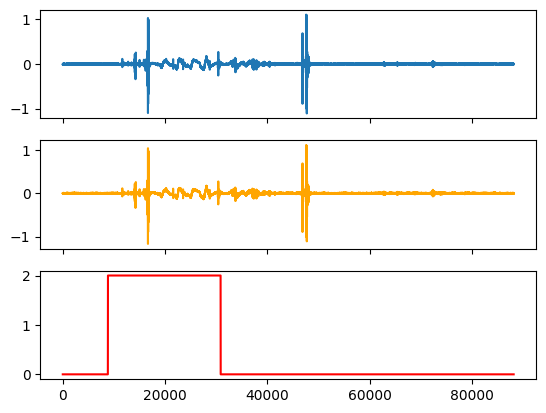

In [89]:
fig,axes = plt.subplots(3, sharex=True)
start_time = (0*3600 + 21*60 + 50) * sample_rate
wave, labels = audioDataset[start_time // chunk_size]
start_time = start_time % chunk_size
axes[0].plot(wave[0,start_time:start_time+20*sample_rate:10].numpy())
axes[1].plot(wave[1,start_time:start_time+20*sample_rate:10].numpy(), color='orange')
axes[2].plot(labels[start_time:start_time+20*sample_rate:10].numpy(), color='red')

In [6]:
# Save as tensors
X = []
y = []
for i in tqdm(range(len(audioDataset))):
    wave, labels = audioDataset[i]
    wave = wave[:,::100] # downsample by 100
    labels = labels[::100]
    X.append(wave)
    y.append(labels)
X = torch.cat(X, dim=1)
y = torch.cat(y)
print(X.shape, y.shape)
outdir = Path('/home/musa/who-opened-the-door/data/april_12_dec100')
outdir.mkdir(exist_ok=True)
torch.save(X, outdir / 'X.pt')
torch.save(y, outdir / 'y.pt')

NameError: name 'audioDataset' is not defined

In [71]:
# import math

# class WindowedAudioDataset(Dataset):
#     def __init__(self, audio_file, labelsfile, window_size, stride, idxs=None):
#         audio_file = str(audio_file)
#         self.audio_file = audio_file
#         self.window_size = window_size
#         self.stride = stride        

#         metadata = torchaudio.info(audio_file)
        
#         self.idxs = idxs
#         self.len_ = len(idxs) if idxs else math.ceil(metadata.num_frames / stride)

#         labels = json.load(open(labelsfile))
#         self.y = torch.zeros(metadata.num_frames, dtype=torch.int64)
#         for label in labels:
#             start = label['start']
#             person = label['label'] # for now, just binary classification so ignore
#             d = datetime.strptime(start, '%H:%M:%S')
#             d = timedelta(hours=d.hour, minutes=d.minute, seconds=d.second)
#             start_time = int(d.total_seconds() * metadata.sample_rate)
#             end_time = start_time + 5 * metadata.sample_rate # 5 seconds
#             self.y[start_time:end_time] = 1

#     def __len__(self):
#         return self.len_

#     def __getitem__(self, idx):
#         if self.idxs:
#             idx = self.idxs[idx]
#         start_frame = idx * self.stride
#         audio_chunk, _ = torchaudio.load(
#             self.audio_file,
#             frame_offset=start_frame,
#             num_frames=self.window_size
#         )
#         if audio_chunk.shape[1] < self.window_size:
#             audio_chunk = torch.cat([audio_chunk, torch.zeros(2, self.window_size - audio_chunk.shape[1])], dim=1)
#         labels = self.y[start_frame:start_frame+self.window_size].mode().values
#         return audio_chunk, labels

In [72]:
# stride = 1*sample_rate
# window_size = 5*sample_rate
# idxs = list(range(0, math.ceil(metadata.num_frames / stride)))
# train_idxs, val_idxs = train_test_split(idxs, test_size=0.2)
# train_idxs.__len__()
# train_dataset = WindowedAudioDataset(audiofile, labelsfile, window_size, stride, train_idxs)
# val_dataset = WindowedAudioDataset(audiofile, labelsfile, window_size, stride, val_idxs)
# trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# testloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [129]:
import math

class WindowedAudioDataset(Dataset):
    def __init__(self, X, y, window_size, stride):
        self.window_size = window_size
        self.stride = stride

        self.X = X
        self.y = y
        self.X = torch.cat([self.X, torch.zeros(X.shape[0], self.window_size-1)], dim=1)
        print(self.X.shape, self.y.shape)

    def __len__(self):
        return math.ceil(self.X.shape[1] / self.stride)

    def __getitem__(self, idx):
        return (
            self.X[:,(idx*self.stride):(idx*self.stride)+self.window_size],
            self.y[(idx*self.stride):(idx*self.stride)+self.window_size]#.mode().values
        )

In [130]:
outdir = Path('/home/musa/who-opened-the-door/data/april_12_dec100')

sample_rate = 44100 // 100
stride = 1*sample_rate
window_size = 5*sample_rate

X = torch.load(outdir / 'X.pt')
y = torch.load(outdir / 'y.pt')

data = torch.cat([X, y.unsqueeze(0)], dim=0).numpy()
np.random.shuffle(data)
X = torch.tensor(data[:-1])
y = torch.tensor(data[-1])

test_size = 0.2
X_train = X[:,:int((1-test_size)*X.shape[1])]
y_train = y[:int((1-test_size)*X.shape[1])]
X_test = X[:,int((1-test_size)*X.shape[1]):]
y_test = y[int((1-test_size)*X.shape[1]):]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

train_dataset = WindowedAudioDataset(X_train, y_train, window_size, stride)
test_dataset = WindowedAudioDataset(X_test, y_test, window_size, stride)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

torch.Size([2, 8800000]) torch.Size([8800000]) torch.Size([2, 2200000]) torch.Size([2200000])
torch.Size([2, 8802204]) torch.Size([8800000])
torch.Size([2, 2202204]) torch.Size([2200000])


In [41]:
from torch import nn

class AudioNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size*2, 10)
        self.fc2 = nn.Linear(10, 1)
    def forward(self, x):
        x = x.flatten(1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [42]:
dec = 100

device = 'cuda'
model = AudioNet(window_size // dec).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [43]:
train_losses = []
val_losses = []
for epoch in (pbar := tqdm(range(10))):
    losses_ = 0
    for X,y in trainloader:
        X = X[:,:,::dec].to(device)
        y = y.unsqueeze(1).float().to(device)
        logits = model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_ += loss.item()
    train_losses.append(losses_ / len(trainloader))

    losses_ = 0
    for X,y in testloader:
        X = X[:,:,::dec].to(device)
        y = y.unsqueeze(1).float().to(device)
        logits = model(X)
        loss = criterion(logits, y)
        losses_ += loss.item()
    val_losses.append(losses_ / len(testloader))

    pbar.set_description(f'Epoch {epoch} train loss: {train_losses[-1]}, val loss: {val_losses[-1]}')

plt.plot(train_losses)
plt.plot(val_losses)

  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x0 and 44x10)

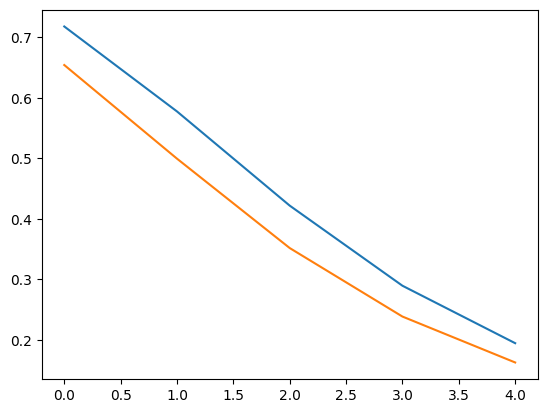

In [83]:
plt.plot(train_losses)
plt.plot(val_losses)